In [1]:
import sys
sys.path.append('..')

import attack
import data_loader as dl

In [2]:
import geopandas as gp
import pandas as pd
from tqdm import tqdm
import numpy as np
import libpysal
import itertools
from joblib import Parallel, delayed
import random
import matplotlib.pyplot as plt

In [3]:
# Load preprocessed data 
raw_full_trip_gdf, raw_trip_sp_gdf, raw_trip_ep_gdf, tesselation_gdf = dl.load_geolife(only_toy_data=True)
assert len(raw_full_trip_gdf) == len(raw_trip_sp_gdf) == len(raw_trip_ep_gdf)

Reading geolife geojson file...
Done.
Number of trajectories in loaded dataset: 312
Number of users in loaded dataset: 5


c:\Users\Bened\Documents\Git\Master-Thesis\env\lib\site-packages\geopandas\geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\Bened\Documents\Git\Master-Thesis\env\lib\site-packages\geopandas\geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\Bened\Documents\Git\Master-Thesis\env\lib\site-packages\geopandas\geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of

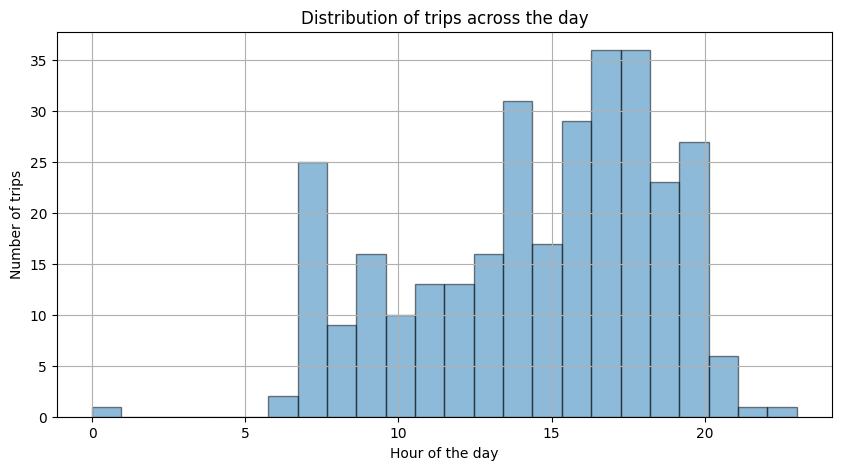


Matching start and end points with tessellation...
Done.

Extracting trips that start and end within tessellation area...
Number of trips that start and end wihin tessellation area: 290
Number of trips outside and therefore dropped: 22
Done.

Building mapping of trip chains...


100%|██████████| 290/290 [00:04<00:00, 59.88it/s]


Done.

Evaluating trip chaining...
Number of edges (matched) between trips: 73
Number of wrong matches: 0
Done.

Building trip chains...


100%|██████████| 290/290 [00:00<00:00, 146495.02it/s]


Done.

Merging trips...


100%|██████████| 290/290 [00:03<00:00, 77.02it/s]


Done.
Number of trips that were matched at least once: 289/290
Concatenating MERGED and UNMERGED trips...
Done.

Extracting data for concatenated trips...
Done.

Building clustering after concatenation...
Number of unique clusters: 218
Done.

Building HL from start points...


c:\Users\Bened\Documents\Git\Master-Thesis\env\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 16 disconnected components.
 There are 9 islands with ids: 12, 14, 15, 18, 20, 26, 27, 49, 51.
  warnings.warn(message)


Done.

Building HL from end points...


c:\Users\Bened\Documents\Git\Master-Thesis\env\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 32 disconnected components.
 There are 24 islands with ids: 5, 28, 29, 30, 38, 39, 40, 41, 42, 49, 50, 53, 54, 58, 59, 60, 63, 64, 73, 74, 79, 110, 111, 112.
  warnings.warn(message)
c:\Users\Bened\Documents\Git\Master-Thesis\env\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 40 disconnected components.
 There are 29 islands with ids: 15, 55, 56, 58, 59, 60, 61, 62, 70, 71, 76, 77, 102, 103, 104, 105, 106, 107, 108, 109, 111, 112, 149, 151, 152, 153, 158, 159, 164.
  warnings.warn(message)


Done.

Combining HL from start points and end points...
Number of users for which at least on Home Location has been identified:  5
Number of unique HL tiles: 40
Done.

Matching trips to HL...
Number of unmatched trajectories (concatenated) that do neither start nor end in a HL tile: 10/218
Number of trajectories (concatenated) that start AND end in a HL tile: 74/218
Number of trips that match different HL tiles with their SP and EP: 44
Done.

Matching double assigned trips to unique HL...
Done.

Getting trajectories that happened during the same time...
Done.

Building clustering after HL matching step...


  0%|          | 0/26 [00:00<?, ?it/s]

Running randomized subset search for 200 iterations with 37 trajectories...
Done. Length of longest subset:  37


 12%|█▏        | 3/26 [00:00<00:01, 12.93it/s]

Running randomized subset search for 200 iterations with 59 trajectories...


 42%|████▏     | 11/26 [00:01<00:01,  9.40it/s]

Done. Length of longest subset:  59
Running randomized subset search for 200 iterations with 45 trajectories...


100%|██████████| 26/26 [00:01<00:00, 15.56it/s]


Done. Length of longest subset:  45
Done.

Clustering results after concatenation step:
Number of unique clusters: 218
Homogeneity: 1.000
Completeness: 0.182
V-measure: 0.308
Rand index: 0.534
ARI: 0.005
MI: 0.963
NMI: 0.308
AMI: 0.081
Cluster accuracy: 0.041

Clustering results after HL matching step:
Number of unique clusters: 34
Homogeneity: 0.974
Completeness: 0.414
V-measure: 0.581
Rand index: 0.697
ARI: 0.368
MI: 0.938
NMI: 0.581
AMI: 0.541
Cluster accuracy: 0.538

Assigning trips without match...
Comparing trips that were not assigned to any HL_ID with trips that were assigned to a HL_ID...


 10%|█         | 1/10 [00:06<00:56,  6.32s/it]

no match and assign new cluster id 35 to trips 11 100


 20%|██        | 2/10 [00:09<00:37,  4.64s/it]

LCSS scores too low to match


 30%|███       | 3/10 [00:12<00:27,  3.92s/it]

existing match and assign cluster id 2.0 to trip 262


 40%|████      | 4/10 [00:18<00:26,  4.45s/it]

existing match and assign cluster id 2.0 to trip 255


 50%|█████     | 5/10 [00:22<00:22,  4.42s/it]

existing match and assign cluster id 6.0 to trip 253


 60%|██████    | 6/10 [00:23<00:12,  3.15s/it]

existing match and assign cluster id 2.0 to trip 1


 70%|███████   | 7/10 [00:25<00:08,  2.94s/it]

existing match and assign cluster id 5.0 to trip 51
There are two or more HL_IDs with the same LCSS score. Looking for second highest LCSS score...
Candidate HL_IDs: [-1.0, 15.0, 17.0]


 80%|████████  | 8/10 [00:30<00:07,  3.67s/it]

There is a unique highest score
The highest score is 1.0 and the best_hl_id is 15.0
existing match and assign cluster id 15.0 to trip 64
There are two or more HL_IDs with the same LCSS score. Looking for second highest LCSS score...
Candidate HL_IDs: [15.0, 18.0]


100%|██████████| 10/10 [00:32<00:00,  3.24s/it]

There is a unique highest score
The highest score is 1.0 and the best_hl_id is 15.0
existing match and assign cluster id 15.0 to trip 101
Done.
Assigning clustering IDs to all trips that are part of a new cluster...
Done.
Done.

Clustering results after concatenation step:
Number of unique clusters: 218
Homogeneity: 1.000
Completeness: 0.182
V-measure: 0.308
Rand index: 0.534
ARI: 0.005
MI: 0.963
NMI: 0.308
AMI: 0.081
Cluster accuracy: 0.041

Clustering results after HL matching step:
Number of unique clusters: 34
Homogeneity: 0.974
Completeness: 0.414
V-measure: 0.581
Rand index: 0.697
ARI: 0.368
MI: 0.938
NMI: 0.581
AMI: 0.541
Cluster accuracy: 0.538

Clustering results after double assign HL step:
Number of unique clusters: 27
Homogeneity: 0.950
Completeness: 0.422
V-measure: 0.584
Rand index: 0.702
ARI: 0.378
MI: 0.915
NMI: 0.584
AMI: 0.551
Cluster accuracy: 0.552

Storing results to csv...
Done.


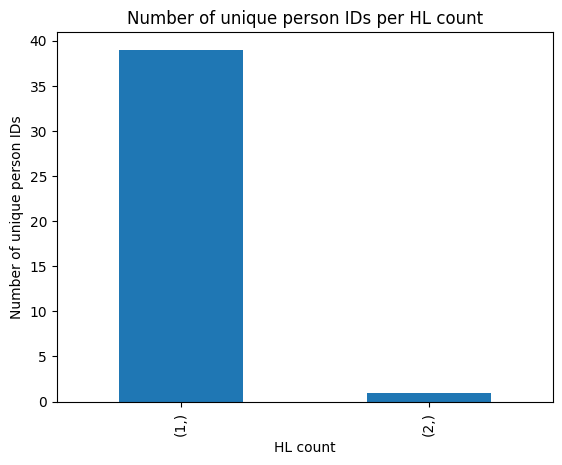

In [4]:
attack.run_full_attack(raw_full_trip_gdf, raw_trip_sp_gdf, raw_trip_ep_gdf, tesselation_gdf)

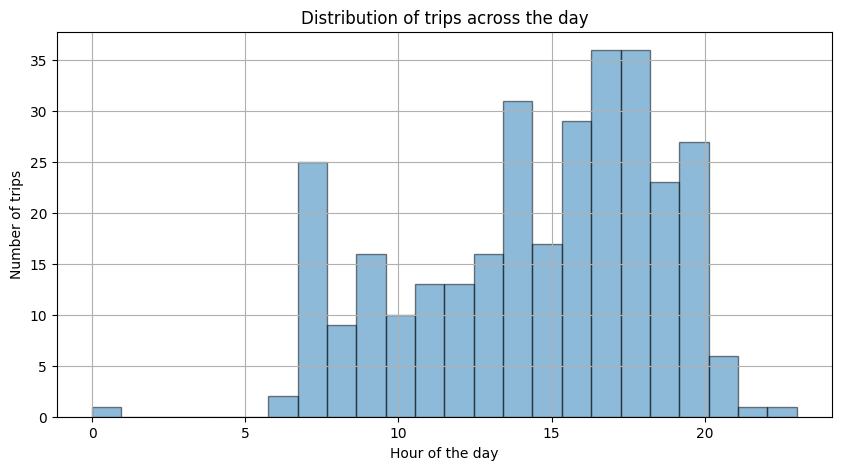

In [6]:
# plot hour of day distribution of TRIP_START
attack.plot_hour_of_day_distribution(raw_full_trip_gdf)

# Merge Start Points (SP) and End Points (EP) with Tessellation

In [7]:
gdf_sp, gdf_ep = attack.match_boundary_points_with_tessellation(raw_trip_sp_gdf, raw_trip_ep_gdf, tesselation_gdf)

# Extract Full Trips that Start and End within Tessellation Area

In [8]:
full_trip_gdf, trip_sp_gdf, trip_ep_gdf, gdf_sp, gdf_ep = attack.extract_trips_that_start_end_in_tessellation(raw_full_trip_gdf, raw_trip_sp_gdf, raw_trip_ep_gdf, gdf_sp, gdf_ep)


Number of trips that start and end wihin tessellation area: 290
Number of trips outside and therefore dropped: 22


## Build mapping of trip chains

In [9]:
mapping_cont_trips = attack.build_trip_chain_mapping(gdf_sp, gdf_ep)

100%|██████████| 290/290 [00:05<00:00, 57.81it/s]


In [10]:
attack.evaluate_trip_chaining(mapping_cont_trips, full_trip_gdf)

Number of edges (matched) between trips: 73
Number of wrong matches: 0


## Merge trips according to matching

In [11]:
full_trips_concat_gdf, trip_concat_dict = attack.merge_trips_from_matching(gdf_sp, mapping_cont_trips, full_trip_gdf)


Building trip chains...


100%|██████████| 290/290 [00:00<00:00, 96704.42it/s]


Done.

Merging trips...


100%|██████████| 290/290 [00:04<00:00, 65.87it/s]

Done.
Number of trips that were matched at least once: 289/290
Concatenating MERGED and UNMERGED trips...
Done.


In [12]:
gdf_sp_concat, trip_sp_gdf_concat, gdf_ep_concat, trip_ep_gdf_concat = attack.extract_concatenated_trips(full_trips_concat_gdf, gdf_sp, trip_sp_gdf, gdf_ep, trip_ep_gdf)

## Build Clustering after Concatenation Step

In [13]:
clustering_concat = attack.build_clustering_after_concatenation(full_trips_concat_gdf, trip_concat_dict, full_trip_gdf)

Number of unique clusters: 218


# Build Home Locations (HL)

## From Start Points (SPs)

We use the SP-tessellation matching that still contains all SP (and potential HL), and not just the SP and EP of the concatenated trips. We do this, because we do not want loose potential HL contributed of substrip concatenated in a chain.

In [14]:
gdf_hl_combined_sp = attack.build_hl_from_start_points(gdf_sp)

c:\Users\Bened\Documents\Git\Master-Thesis\env\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 16 disconnected components.
 There are 9 islands with ids: 12, 14, 15, 18, 20, 26, 27, 49, 51.
  warnings.warn(message)


## From End Points (EPs)

In [15]:
gdf_hl_combined_ep = attack.build_hl_from_end_points(gdf_ep)

c:\Users\Bened\Documents\Git\Master-Thesis\env\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 32 disconnected components.
 There are 24 islands with ids: 5, 28, 29, 30, 38, 39, 40, 41, 42, 49, 50, 53, 54, 58, 59, 60, 63, 64, 73, 74, 79, 110, 111, 112.
  warnings.warn(message)


## Merge (concatenate)

c:\Users\Bened\Documents\Git\Master-Thesis\env\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 40 disconnected components.
 There are 29 islands with ids: 15, 55, 56, 58, 59, 60, 61, 62, 70, 71, 76, 77, 102, 103, 104, 105, 106, 107, 108, 109, 111, 112, 149, 151, 152, 153, 158, 159, 164.
  warnings.warn(message)


Number of users for which at least on Home Location has been identified:  5
Number of unique HL tiles: 40


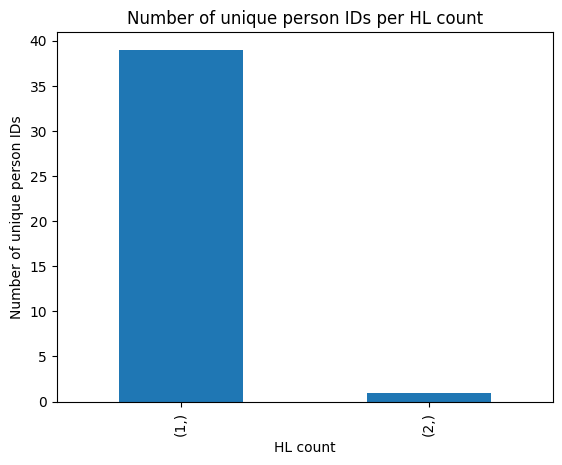

In [16]:
gp_combined, HL_table = attack.concatenate_hl(gdf_hl_combined_sp, gdf_hl_combined_ep)

# Match trips with Home Location tiles

## Match concatenated trips

In [17]:
HL_table_se_concat, unmatched_trips, double_assigned_trips, nr_unmatched = attack.match_trips_to_HL(gp_combined, HL_table, trip_sp_gdf_concat, trip_ep_gdf_concat, full_trips_concat_gdf)

Number of unmatched trajectories (concatenated) that do neither start nor end in a HL tile: 10/218
Number of trajectories (concatenated) that start AND end in a HL tile: 74/218
Number of trips that match different HL tiles with their SP and EP: 44


## Assign double matched trips to one unique HL

Iterate over all double matched trips and compare them to all other trips that are uniquely assigned in their respective potential HLs that they have been matched with. Then take the HL with the single maximum lcss score between the trip under question and any trip of the assigned HL tiles.

In [18]:
HL_table_trips_concat = attack.assign_double_matched_trips_to_unique_hl(HL_table_se_concat, full_trips_concat_gdf, unmatched_trips, double_assigned_trips, nr_unmatched)


## Get trajectories that happened during the same time

In [19]:
full_trips_concat_gdf_overlap_dict = attack.getTripOverlaps(full_trips_concat_gdf)

## Create clustering after HL assignment step

In [20]:
clustering_after_HL, HL_table_dict = attack.build_clustering_after_HL_assignment(HL_table_trips_concat, full_trip_gdf, trip_concat_dict, full_trips_concat_gdf_overlap_dict)

  0%|          | 0/26 [00:00<?, ?it/s]

Running randomized subset search for 200 iterations with 37 trajectories...


 12%|█▏        | 3/26 [00:00<00:05,  4.39it/s]

Done. Length of longest subset:  37
Running randomized subset search for 200 iterations with 59 trajectories...


 42%|████▏     | 11/26 [00:01<00:02,  5.87it/s]

Done. Length of longest subset:  59
Running randomized subset search for 200 iterations with 45 trajectories...


100%|██████████| 26/26 [00:02<00:00, 10.46it/s]

Done. Length of longest subset:  45


In [21]:
print("Clustering results after concatenation step:")
print(f"Number of unique clusters: {len(set(clustering_concat))}")
attack.evaluate(clustering_concat, full_trip_gdf)

clustering_HL = list(dict(sorted(clustering_after_HL.items())).values())
print("\nClustering results after HL matching step:")
print(f"Number of unique clusters: {len(set(clustering_HL))}")
attack.evaluate(clustering_HL, full_trip_gdf)

Clustering results after concatenation step:
Number of unique clusters: 218
Homogeneity: 1.000
Completeness: 0.182
V-measure: 0.308
Rand index: 0.534
ARI: 0.005
MI: 0.963
NMI: 0.308
AMI: 0.081

Clustering results after HL matching step:
Number of unique clusters: 34
Homogeneity: 0.974
Completeness: 0.414
V-measure: 0.581
Rand index: 0.697
ARI: 0.368
MI: 0.938
NMI: 0.581
AMI: 0.541


## Try to Assign Trips Without Match

In [22]:
clustering_after_double_assign_HL = attack.assign_trips_without_match(
    clustering_after_HL, HL_table_dict, 
    full_trips_concat_gdf, 
    full_trips_concat_gdf_overlap_dict, 
    full_trip_gdf, 
    trip_concat_dict)


Comparing trips that were not assigned to any HL_ID with trips that were assigned to a HL_ID...


 10%|█         | 1/10 [00:05<00:46,  5.11s/it]

no match and assign new cluster id 35 to trips 11 100


 20%|██        | 2/10 [00:08<00:30,  3.82s/it]

LCSS scores too low to match


 30%|███       | 3/10 [00:10<00:23,  3.35s/it]

existing match and assign cluster id 2.0 to trip 262


 40%|████      | 4/10 [00:15<00:22,  3.78s/it]

existing match and assign cluster id 2.0 to trip 255


 50%|█████     | 5/10 [00:19<00:19,  4.00s/it]

existing match and assign cluster id 6.0 to trip 253


 60%|██████    | 6/10 [00:20<00:11,  2.94s/it]

existing match and assign cluster id 2.0 to trip 1


 70%|███████   | 7/10 [00:23<00:08,  2.89s/it]

existing match and assign cluster id 5.0 to trip 51
There are two or more HL_IDs with the same LCSS score. Looking for second highest LCSS score...
Candidate HL_IDs: [-1.0, 15.0, 17.0]


 80%|████████  | 8/10 [00:29<00:07,  3.81s/it]

There is a unique highest score
The highest score is 1.0 and the best_hl_id is 15.0
existing match and assign cluster id 15.0 to trip 64
There are two or more HL_IDs with the same LCSS score. Looking for second highest LCSS score...
Candidate HL_IDs: [15.0, 18.0]


100%|██████████| 10/10 [00:30<00:00,  3.04s/it]

There is a unique highest score
The highest score is 1.0 and the best_hl_id is 15.0
existing match and assign cluster id 15.0 to trip 101
Done.
Assigning clustering IDs to all trips that are part of a new cluster...
Done.


In [23]:
print("Clustering results after concatenation step:")
print(f"Number of unique clusters: {len(set(clustering_concat))}")
attack.evaluate(clustering_concat, full_trip_gdf)

print("\nClustering results after HL matching step:")
print(f"Number of unique clusters: {len(set(list(dict(sorted(clustering_after_HL.items())).values())))}")
attack.evaluate(list(dict(sorted(clustering_after_HL.items())).values()), full_trip_gdf)

print("\nClustering results after double assign HL step:")
print(f"Number of unique clusters: {len(set(list(dict(sorted(clustering_after_double_assign_HL.items())).values())))}")
attack.evaluate(list(dict(sorted(clustering_after_double_assign_HL.items())).values()), full_trip_gdf)

Clustering results after concatenation step:
Number of unique clusters: 218
Homogeneity: 1.000
Completeness: 0.182
V-measure: 0.308
Rand index: 0.534
ARI: 0.005
MI: 0.963
NMI: 0.308
AMI: 0.081

Clustering results after HL matching step:
Number of unique clusters: 34
Homogeneity: 0.974
Completeness: 0.414
V-measure: 0.581
Rand index: 0.697
ARI: 0.368
MI: 0.938
NMI: 0.581
AMI: 0.541

Clustering results after double assign HL step:
Number of unique clusters: 27
Homogeneity: 0.950
Completeness: 0.422
V-measure: 0.584
Rand index: 0.702
ARI: 0.378
MI: 0.915
NMI: 0.584
AMI: 0.551


In [32]:
attack.store_results(clustering_concat, list(dict(sorted(clustering_after_HL.items())).values()), list(dict(sorted(clustering_after_double_assign_HL.items())).values()), full_trip_gdf)